In [11]:
import numpy as np
import matplotlib.pyplot as plt
from antOptimization import AntColony,AntTime


def generate_random_distance_matrix(size):
    # 生成一个随机的距离矩阵，矩阵大小为 size x size
    np.random.seed(42)  # 设置随机种子以确保结果的可重复性
    distances = np.random.uniform(1, 100, size=(size, size))  # 生成随机距离，范围1到100
    distances = np.round(distances, 2)

    distances = (distances + distances.T) / 2  # 使矩阵对称，确保距离的一致性
    np.fill_diagonal(distances, np.inf)  # 设置对角线为无穷大，表示自己到自己的距离
    return distances


In [12]:
import numpy as np
import random
from numpy.random import choice as np_choice
import time


class AntColony():
    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        distances : 2D array
            Square matrix of distances. Diagonal is assumed to be np.inf.
        n_ants : int
            Number of ants running per iteration
        n_best : int
            Number of best ants who deposit pheromone
        n_iteration : int
            Number of iterations
        decay : float
            Rate it which pheromone decays. The pheromone value is multiplied by decay,
            so 0.95 will lead to decay, 0.5 to much faster decay.
        alpha : int or float
            Exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
        beta : int or float
            Exponent on distance, higher beta give distance more weight. Default=1
        """
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        iteration_shortest_paths = []  # List to store each iteration's shortest path
        convergence_threshold = 0.01  # 定义收敛阈值
        convergence_count = 5  # 定义需要连续多少次小于阈值才认为收敛
        convergence_iterations = 0  # 初始化连续达到阈值的次数
        previous_shortest_distance = np.inf  # 初始化前一次的最短路径长度

        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            iteration_shortest_paths.append(shortest_path[1])  # Append current iteration's shortest distance
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone = self.pheromone * self.decay
            # 判断是否收敛
            distance_improvement = previous_shortest_distance - shortest_path[1]
            if distance_improvement < convergence_threshold:
                convergence_iterations += 1
                # print(distance_improvement)
            else:
                # print(distance_improvement)
                convergence_iterations = 0  # 重置连续达到阈值的次数
            if convergence_iterations >= convergence_count:
                print(f"Algorithm has converged after {i+1} iterations.")
                break  # 收敛，跳出循环            
            previous_shortest_distance = shortest_path[1]  # 更新前一次的最短路径长度
        return all_time_shortest_path, iteration_shortest_paths, i+1  # Return the all-time shortest path and list of iteration shortest paths

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        """
        calculate the distance of the path
        """
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        """
        create a list of moves(in tuple) with length of the number of cities - 1
        """
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path

    def pick_move(self, pheromone, dist, visited):
        """
        轮盘赌法
        """
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)    # possibility

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]   # p is the possibility of each move
        return move



class AntTime(AntColony):
    def run(self):
        start_time = time.time()  # Record the start time
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        iteration_shortest_paths = []  # List to store each iteration's shortest path
        convergence_threshold = 0.01  # 定义收敛阈值
        convergence_count = 5  # 定义需要连续多少次小于阈值才认为收敛
        convergence_iterations = 0  # 初始化连续达到阈值的次数
        previous_shortest_distance = np.inf  # 初始化前一次的最短路径长度

        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            iteration_shortest_paths.append(shortest_path[1])  # Append current iteration's shortest distance
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone = self.pheromone * self.decay
            # 判断是否收敛
            distance_improvement = previous_shortest_distance - shortest_path[1]
            if distance_improvement < convergence_threshold:
                convergence_iterations += 1
                # print(distance_improvement)
            else:
                # print(distance_improvement)
                convergence_iterations = 0  # 重置连续达到阈值的次数
            if convergence_iterations >= convergence_count:
                print(f"Algorithm has converged after {i+1} iterations.")
                break  # 收敛，跳出循环            
            previous_shortest_distance = shortest_path[1]  # 更新前一次的最短路径长度
        end_time = time.time()  # Record the end time
        execution_time = end_time - start_time  # Calculate the execution time
        return execution_time  # Return the all-time shortest path and list of iteration shortest paths


In [4]:

# 生成80*80的随机距离矩阵
size = 80
distances = generate_random_distance_matrix(size)
distances


array([[   inf, 90.785, 55.44 , ..., 12.325, 64.275, 37.33 ],
       [90.785,    inf, 48.68 , ..., 53.61 , 17.46 , 62.265],
       [55.44 , 48.68 ,    inf, ..., 14.53 , 59.885, 36.78 ],
       ...,
       [12.325, 53.61 , 14.53 , ...,    inf, 72.48 , 61.56 ],
       [64.275, 17.46 , 59.885, ..., 72.48 ,    inf, 24.26 ],
       [37.33 , 62.265, 36.78 , ..., 61.56 , 24.26 ,    inf]])

In [13]:
excecution_time=[]
number_ants=[]
for i in range(1,60,5):
    ant_colony = AntTime(distances, n_ants=60, n_best=i,
                            n_iterations=100, decay=0.5, alpha=1, beta=2)
    Time= ant_colony.run()
    number_ants.append(i)
    excecution_time.append(Time)

Algorithm has converged after 17 iterations.
Algorithm has converged after 18 iterations.
Algorithm has converged after 47 iterations.
Algorithm has converged after 39 iterations.
Algorithm has converged after 50 iterations.
Algorithm has converged after 39 iterations.
Algorithm has converged after 26 iterations.
Algorithm has converged after 46 iterations.
Algorithm has converged after 73 iterations.


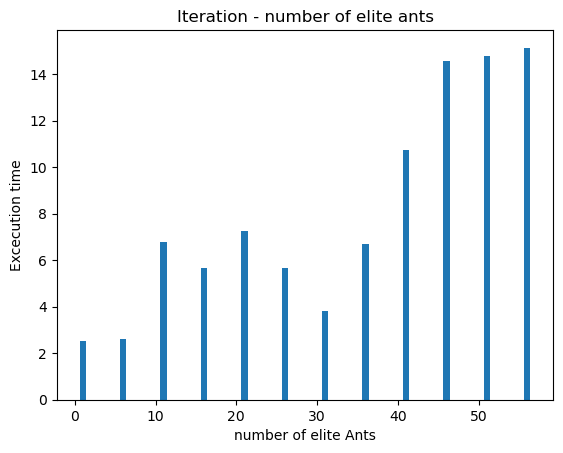

In [14]:
plt.figure()  # 设置图像大小
plt.bar(number_ants,excecution_time)  # 画柱状图，X轴是迭代次数，Y轴是距离值

# 设置图表标题和轴标签
plt.title(f'Iteration - number of elite ants')
plt.xlabel('number of elite Ants')
plt.ylabel('Excecution time')
# 显示图表
plt.show()


In [26]:
excecution_time=[]
number_ants=[]
for i in range(1,10,1):
    i=i/10
    ant_colony = AntTime(distances, n_ants=60, n_best=5,
                            n_iterations=100, decay=i, alpha=1, beta=2)
    Time = ant_colony.run()
    number_ants.append(i)
    excecution_time.append(Time)

0.1
Algorithm has converged after 16 iterations.
0.2
Algorithm has converged after 16 iterations.
0.3
Algorithm has converged after 20 iterations.
0.4
Algorithm has converged after 19 iterations.
0.5
Algorithm has converged after 27 iterations.
0.6
Algorithm has converged after 30 iterations.
0.7
Algorithm has converged after 52 iterations.
0.8
Algorithm has converged after 76 iterations.
0.9
Algorithm has converged after 89 iterations.


In [32]:
print(excecution_time)
print(number_ants)

[2.4969470500946045, 2.3493902683258057, 2.909846782684326, 2.765807867050171, 3.9675331115722656, 4.609447240829468, 7.690804958343506, 11.316339015960693, 12.820970058441162]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


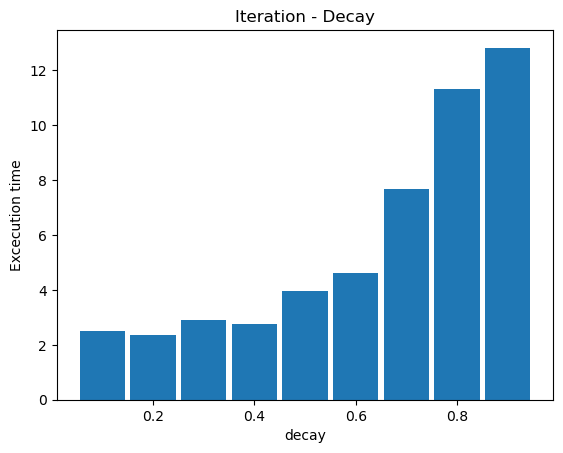

In [35]:
plt.figure()  # 设置图像大小
plt.bar(number_ants,excecution_time,width=0.09)  # 画柱状图，X轴是迭代次数，Y轴是距离值

# 设置图表标题和轴标签
plt.title(f'Iteration - Decay')
plt.xlabel('decay')
plt.ylabel('Excecution time')
# 显示图表
plt.show()


In [36]:
excecution_time=[]
number_ants=[]
for i in range(1,20,2):
    i=i/10
    ant_colony = AntTime(distances, n_ants=60, n_best=5,
                            n_iterations=100, decay=0.4, alpha=i, beta=2)
    Time = ant_colony.run()
    number_ants.append(i)
    excecution_time.append(Time)

Algorithm has converged after 68 iterations.
Algorithm has converged after 58 iterations.
Algorithm has converged after 29 iterations.
Algorithm has converged after 20 iterations.
Algorithm has converged after 14 iterations.
Algorithm has converged after 15 iterations.
Algorithm has converged after 10 iterations.
Algorithm has converged after 14 iterations.


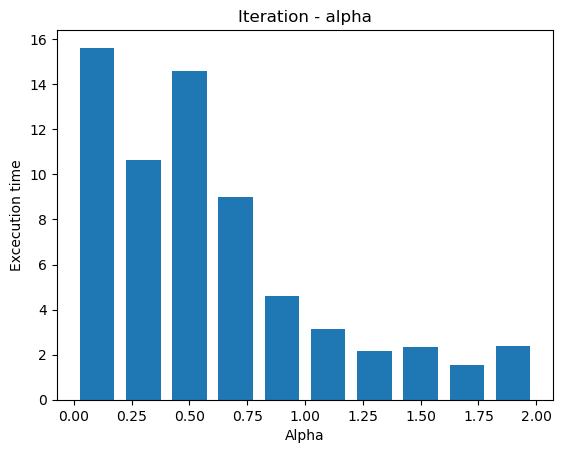

In [37]:
plt.figure()  # 设置图像大小
plt.bar(number_ants,excecution_time,width=0.15)  # 画柱状图，X轴是迭代次数，Y轴是距离值

# 设置图表标题和轴标签
plt.title(f'Iteration - alpha')
plt.xlabel('Alpha')
plt.ylabel('Excecution time')
# 显示图表
plt.show()


In [38]:
excecution_time=[]
number_ants=[]
for i in range(1,40,3):
    i=i/10
    ant_colony = AntTime(distances, n_ants=60, n_best=5,
                            n_iterations=100, decay=0.4, alpha=1.25, beta=i)
    Time = ant_colony.run()
    number_ants.append(i)
    excecution_time.append(Time)

Algorithm has converged after 26 iterations.
Algorithm has converged after 23 iterations.
Algorithm has converged after 17 iterations.
Algorithm has converged after 16 iterations.
Algorithm has converged after 16 iterations.
Algorithm has converged after 16 iterations.
Algorithm has converged after 16 iterations.
Algorithm has converged after 15 iterations.
Algorithm has converged after 20 iterations.
Algorithm has converged after 16 iterations.
Algorithm has converged after 13 iterations.
Algorithm has converged after 12 iterations.
Algorithm has converged after 18 iterations.


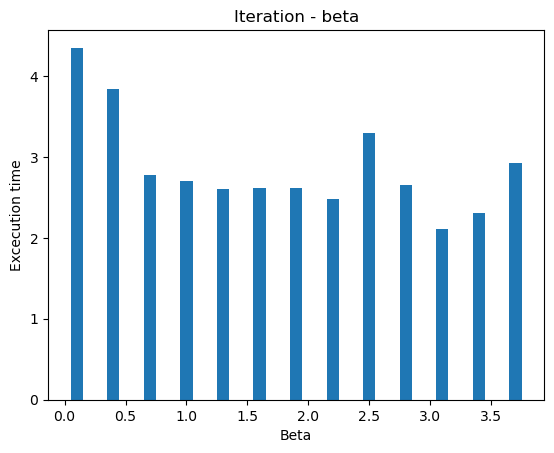

In [39]:
plt.figure()  # 设置图像大小
plt.bar(number_ants,excecution_time,width=0.1)  # 画柱状图，X轴是迭代次数，Y轴是距离值

# 设置图表标题和轴标签
plt.title(f'Iteration - beta')
plt.xlabel('Beta')
plt.ylabel('Excecution time')
# 显示图表
plt.show()

In [46]:

ant_colony = AntColony(distances, n_ants=60, n_best=5,
                            n_iterations=100, decay=0.4, alpha=1.25, beta=3.0)
shortest_path,dis, iterations = ant_colony.run()


print(f'optimal distance = {dis[-1]}')


Algorithm has converged after 20 iterations.
optimal distance = 918.5100000000002


In [47]:
iteration=100

ant_colony = AntColony(distances, n_ants=100, n_best=10,
                        n_iterations=iteration, decay=0.5, alpha=1, beta=2)
shortest_path,dis, iterations = ant_colony.run()
print(f'optimal distance = {dis[-1]}')



Algorithm has converged after 26 iterations.
optimal distance = 922.2850000000004
